<a href="https://colab.research.google.com/github/mini3713/mini3713/blob/main/occupancy/test_1228_silhouette%26add_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
### k-means가 아닌 time-series k-means로 작성함 
def visualize_silhouette(cluster_lists, X_features): 

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = TimeSeriesKMeans(n_clusters = n_cluster, max_iter=2, metric="euclidean", random_state=42, n_jobs=-1)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [2]:
!pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
import pandas as pd
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 875 kB 11.5 MB/s 


In [ ]:
df = pd.read_excel('/content/Time use survey_Korea_2019_onehot_only.xlsx')
df = df.drop(['Unnamed: 0'], axis=1)

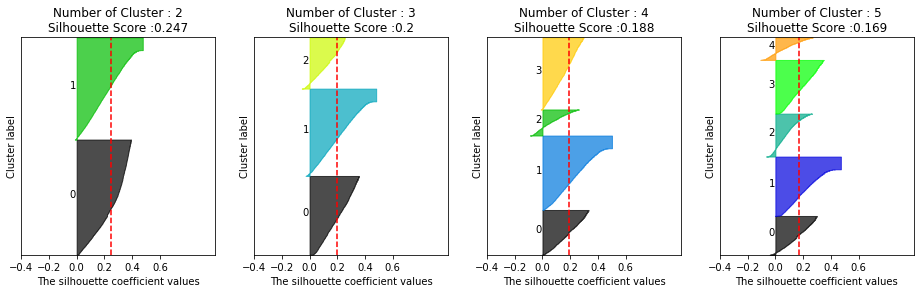

In [ ]:
visualize_silhouette([2, 3, 4, 5], df)

* 평균 실루엣점수가 모두 0.3이하로 산출되어 one-hot encoding으로는 특정 패턴으로 clustering이 어려울 것으로 판단됨
* 참고로 실루엣점수는 대체로 0.5 이상이면 매우 양호한것으로 판단됨
* 특성을 더 추가해서 clustering 하면 .. 그래도 특정 패턴을 찾을 수 있지 않을까? 
* 따라서, "장소코드 + 주행동코드"를 붙여서 clustering을 진행해보려고 한다 
* "주행동코드 + 장소코드"도 가능하지만 데이터의 진동이 커지기 때문에 "장소코드 + 주행동코드" 로 데이터 변환 

In [ ]:
total = pd.read_csv("/content/Time use survey_Korea_2019.csv", encoding="cp949")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (20,21,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
t = total.iloc[:,12:]

## **add features**

In [ ]:
for i in range(0, t.shape[0]) : 
    for k in range(0, t.shape[1]) :  
        a = str(t.iloc[int(i), int(k)])    

        if a[4:6] == '01' :          
            t.iloc[int(i), int(k)] = '1' + a[0:2]
            
        else : t.iloc[int(i), int(k)] = 0

In [ ]:
t.to_excel(excel_writer='Time use survey_Korea_2019_3code.xlsx')

In [ ]:
data = pd.read_excel('/content/Time use survey_Korea_2019_3code.xlsx')

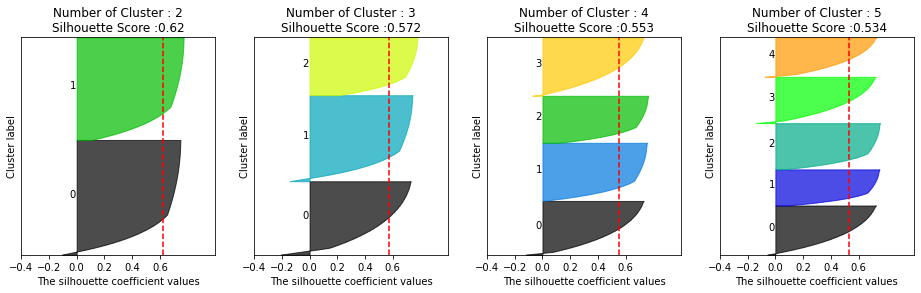

In [ ]:
visualize_silhouette([2, 3, 4, 5], data)

* By silhouette analysis, I think the number 2 or 4 is appropriate for clustering numbers...  

In [ ]:
### 클러스터의 평균을 꺾은선그래프로 시각화해주는 함수 (ing...)
 
def visualize_clusterave(cluster_lists, X_features): # (k(클러스터개수), x_features)

  # 크게 클러스터링 수행> 시각화 두단계로 구성할 예정.. 

=================================

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = TimeSeriesKMeans(n_clusters = n_cluster, max_iter=2, metric="euclidean", random_state=42, n_jobs=-1)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")